In [1]:
# NumPy library: allows for numerical computing
import numpy as np

# pandas library: used for data manipulation and analysis
import pandas as pd

# matplotlib library: plots everything
import matplotlib.pyplot as plt
%matplotlib inline

_________

# Case II

__Best Asset Management (BAM) is a top-notch asset management company with operations worldwide. Your team got an internship opportunity and your first assignment is to help in the advisory process for a wealthy investor, Mr. Gonzalez.__

__
Mr. Gonzalez approached BAM for the development of an investment strategy more adjusted to his risk-return profile. Your internship supervisor, Mrs. Crusoe, wants you to conduct a comprehensive analysis on what might be a good asset allocation for this investor.__

In [13]:
# Import the excel file
data = pd.read_excel('./data_case.xlsx', index_col='Date')

# Order the columns in alphabetical order
data = data.reindex(sorted(data.columns), axis=1).drop(pd.Timestamp('2004-12-31'))

# Show the data
data.head()

,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
Date,,,,,
2005-01-07,0.061548,0.014354,0.019900,0.028100,-0.007989
2005-01-14,0.037780,-0.003776,0.003577,-0.003210,-0.007760
2005-01-21,0.007729,-0.007996,0.001278,0.001171,0.009977
2005-01-28,-0.013148,0.006571,0.002871,0.001559,-0.018529
2005-02-04,-0.009279,0.033628,0.012232,0.017711,0.032902


__ For your assignment Mrs. Crusoe gave you weekly data on several asset classes that she considers appropriate for the investor and raised some questions that she believes will strengthen your analysis.__

__The risk-free rate is 3%.__

In [3]:
# Define the risk-free variable
r_f = 0.03

__________________

## Question 1

__ How did each of the asset classes performed throughout the whole sample period?__

In [4]:
# Create table, DataFrame, with historical indicators
sample_indicators = pd.DataFrame({'mean': data.mean()*(365.25/7), 
                                  'std': data.std() * np.sqrt(365.25/7),
                                  'min': data.min(),
                                  'max': data.max()})

# Show table
sample_indicators

,max,mean,min,std
Commodities,0.143364,0.057562,-0.182563,0.215036
Equity,0.109478,0.094019,-0.179928,0.163920
Fixed income,0.059763,0.044750,-0.033792,0.070888
Hedge Funds,0.042825,0.023183,-0.051908,0.098036
Real Estate,0.174583,0.087123,-0.143572,0.208388


In [5]:
# Get covariance variance matrix
S = data.cov()*(365.25/7)

# Show it
S

,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
Commodities,0.046241,0.014588,-0.000341,0.005410,0.012579
Equity,0.014588,0.026870,0.000484,0.008068,0.027308
Fixed income,-0.000341,0.000484,0.005025,0.004740,0.000799
Hedge Funds,0.005410,0.008068,0.004740,0.009611,0.006834
Real Estate,0.012579,0.027308,0.000799,0.006834,0.043426


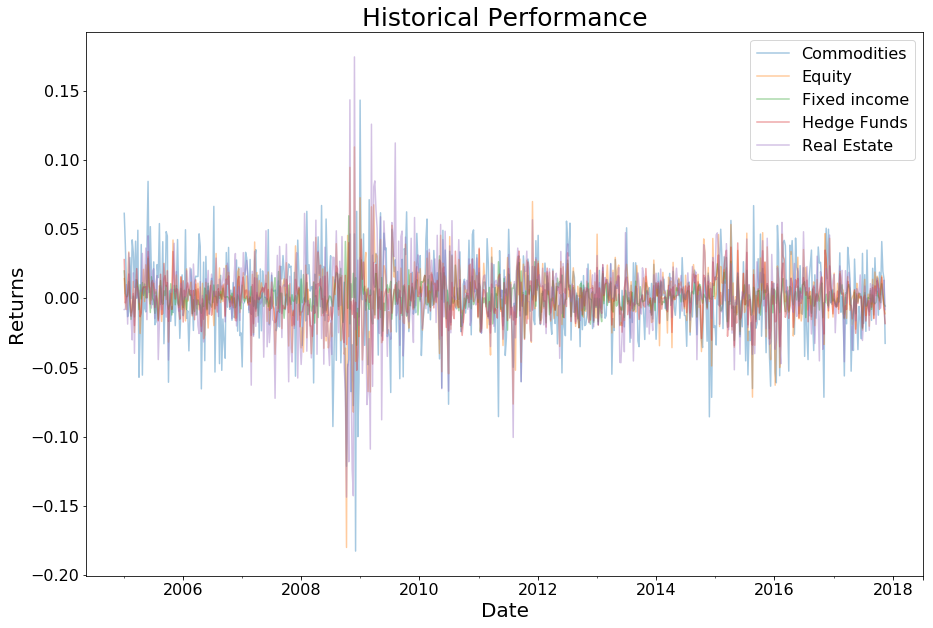

In [7]:
# Visualize the returns
data.plot(alpha=.4, figsize = (15,10), title='Data')

## Define the labels
plt.title('Historical Performance', fontsize=25)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Returns', fontsize=20)
plt.rc('font', size=16);

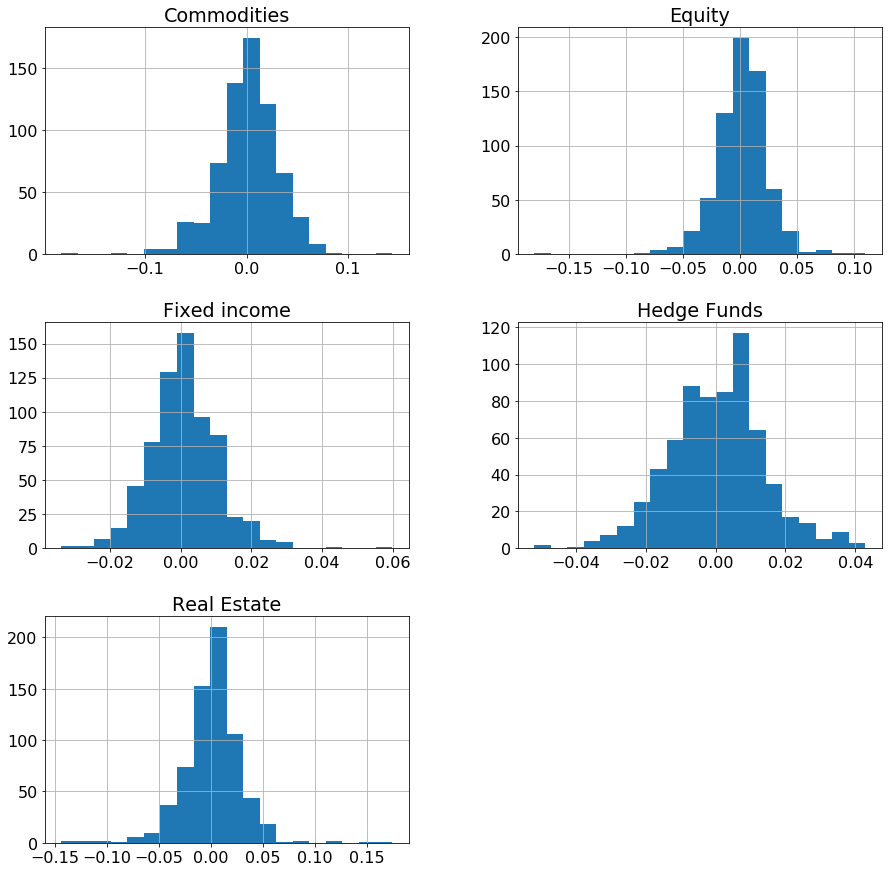

In [8]:
# Plot a histogram using 20 bins of the 5 asset classes
pd.DataFrame.hist(data, bins=20, figsize = (15,15), xlabelsize=16);

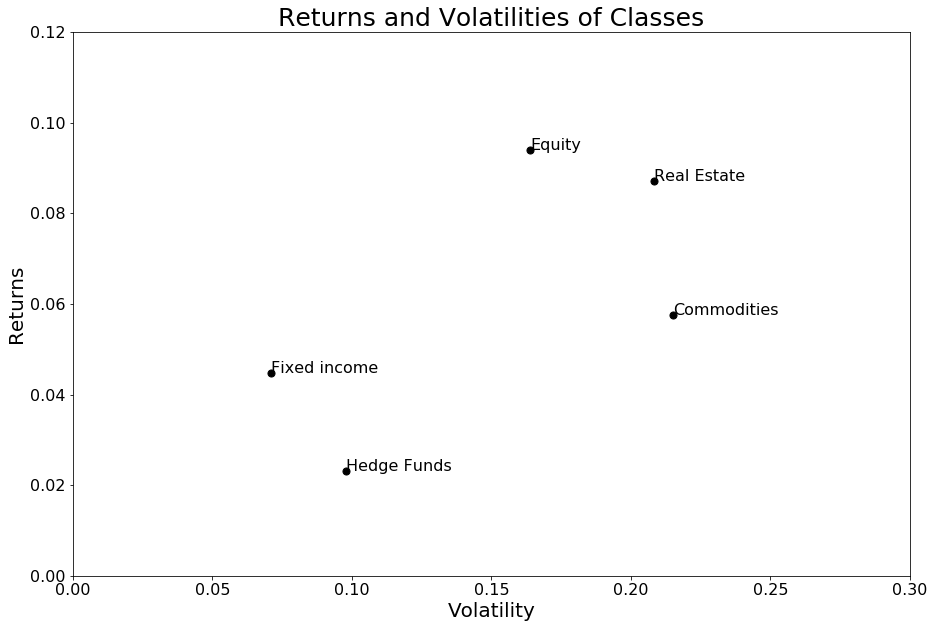

In [9]:
# Plot the Returns Volatility scatter
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(sample_indicators['std'], sample_indicators['mean'], marker="o",color='xkcd:black',s=50)

# Add the labels to each class
for i, txt in enumerate(data.columns.tolist()):
    ax.annotate(txt, (sample_indicators['std'].tolist()[i],sample_indicators['mean'].tolist()[i]))

# Define the limits for the graph
plt.ylim((0.00,0.12))
plt.xlim((0.00,0.3))

# Define the labels
plt.title('Returns and Volatilities of Classes', fontsize=25)
plt.xlabel('Volatility', fontsize=20)
plt.ylabel('Returns', fontsize=20);

plt.rc('font', size=16);

___________

## Question 2

__ If there are no restrictions on short sales what would be the tangency portfolio? And if the investor is restricted on short sales? Compare the two portfolios.__

Firstly, with no restriction:

$$ weights_{T_{nr}} = \frac{S^{-1}\{E(r)-r_f\}}{Sum\left[S^{-1}\{E(r)-r_f\}\right]} $$

In [10]:
# Get weights of tangent portfolio with no restrictions:
w_T_nr = np.dot(np.linalg.inv(S), sample_indicators['mean'] - r_f)/sum(np.dot(np.linalg.inv(S), sample_indicators['mean']- r_f))

# Display weights
print(w_T_nr)

[ 0.03964144  1.00047184  1.93136873 -1.72722291 -0.24425909]


In [11]:
# Get expected return of the tangency portfolio
E_r_T_nr = np.dot(w_T_nr, sample_indicators['mean'])

# Get standard deviation of the tangency portfolio
std_T_nr = np.sqrt(np.dot(np.transpose(w_T_nr), np.dot(S, w_T_nr)))

# Print E(r) and std
print('E(r):', E_r_T_nr)
print('σ:', std_T_nr)

E(r): 0.121451164838
σ: 0.105497771132


<br>

Secondly, with restrictions:

In [12]:
# Set Monte Carlo approach with 1M portfolios
num_portfolios = 1000000

# List of stocks in portfolio
stocks = data.columns.tolist()

# Set up table to hold results
results = np.zeros((4+len(stocks)-1,num_portfolios))

# Loop through all the portfolios
for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.array(np.random.random(5))
    
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(sample_indicators['mean'] * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(S, weights)))
 
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    
    #store Sharpe Ratio
    results[2,i] = (results[0,i]-r_f) / results[1,i]
    
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

# Convert the table
results_table_r = pd.DataFrame(results.T,columns=['ret','stdev','sharpe',stocks[0],stocks[1],stocks[2],stocks[3],stocks[4]])
results_table_r.head()

,ret,stdev,sharpe,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
0,0.048871,0.089514,0.210815,0.204139,0.004189,0.315807,0.295041,0.180823
1,0.072004,0.119620,0.351146,0.226760,0.338068,0.234734,0.012522,0.187916
2,0.064536,0.110596,0.312272,0.150978,0.415719,0.147022,0.230858,0.055422
3,0.060612,0.105861,0.289172,0.251358,0.180460,0.247599,0.153798,0.166785
4,0.045365,0.096381,0.159416,0.304704,0.018643,0.253849,0.346001,0.076803


In [14]:
# Locate position of portfolio with highest Sharpe Ratio
max_sharpe_r = results_table_r.iloc[results_table_r['sharpe'].idxmax()]

# Locate positon of portfolio with minimum standard deviation
min_vol_r = results_table_r.iloc[results_table_r['stdev'].idxmin()]

# Get weights of tangent portfolio with no restrictions:
w_T_r = np.transpose(max_sharpe_r[3:].tolist())

# Display weights
print(w_T_r)

[ 0.00593435  0.49927927  0.48863806  0.00135197  0.00479634]


In [15]:
# Get expected return of the tangency portfolio
E_r_T_r = np.dot(w_T_r, sample_indicators['mean'])

# Get standard deviation of the tangency portfolio
std_T_r = np.sqrt(np.dot(np.transpose(w_T_r), np.dot(S, w_T_r)))

# Print E(r) and std
print('E(r):', E_r_T_r)
print('σ:', std_T_r)

E(r): 0.0695993356334
σ: 0.0915097958658


<br>

Comparing both restricted and not restricted:

In [16]:
# Create table to show results
question_2 = pd.DataFrame({'T_nr': [E_r_T_nr, std_T_nr], 
                           'T_r': [E_r_T_r, std_T_r]}, index=['E(r)', 'σ'])
question_2

,T_nr,T_r
E(r),0.121451,0.069599
σ,0.105498,0.091510


_______

## Question 3

__  Assuming an investor with a quadratic function 𝑈𝑥 = 𝐸(𝑟) − 𝛾/2 × 𝜎^2 and a risk aversion level (𝛾) of 6, what would be the optimal portfolio if Mr. Gonzalez has no restrictions on short sales? How does your answer change if he has restrictions on short sales? Compare the two recommendations and analyze how they behave for different levels of risk aversion.__

In [17]:
# Define gamma
gamma = 6.0

In [18]:
# Define function that outputs E(r) and std for a given aversion level
def Optimal_ret_and_std_per_gamma(E_r_T, std_T, gamma_value):
    # Calculate the weight of T on the optimal portfolio
    w_T = (E_r_T-r_f)/(gamma_value*(std_T**2))
    
    # Get expected return of the optimal portfolio
    E_r_o = w_T*E_r_T + (1-w_T)*r_f
    
    # Get standard deviation of the optimal portfolio
    std_o = w_T*std_T
    
    # Indicate the otputs of the function
    return(w_T, E_r_o, std_o)

Weight of the tangency porfolio on the optimal portfolio: 
$$ w_T = \frac{r_T-r_f}{\gamma \sigma_T^2} $$

<br>

Firstly, with no restrictions:

In [19]:
# Run the function with the E(r), std, and gamma specific to no restrictions
w_T_nr, E_r_o_nr , std_o_nr = Optimal_ret_and_std_per_gamma(E_r_T_nr, std_T_nr, gamma)

# Add the results to the compare_table
question_3 = question_2.copy()
question_3['o_nr_6'] = [E_r_o_nr, std_o_nr]

In [20]:
# An example for the code for this graph is present bellow

<br>

Secondly, with restrictions:

In [21]:
# Run the function with the E(r), std, and gamma specific to restrictions
w_T_r, E_r_o_r , std_o_r = Optimal_ret_and_std_per_gamma(E_r_T_r, std_T_r, gamma)

# Add the results to the compare_table
question_3['o_r_6'] = [E_r_o_r, std_o_r]

In [2]:
def graph_formulas(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x)
    plt.plot(x, y)

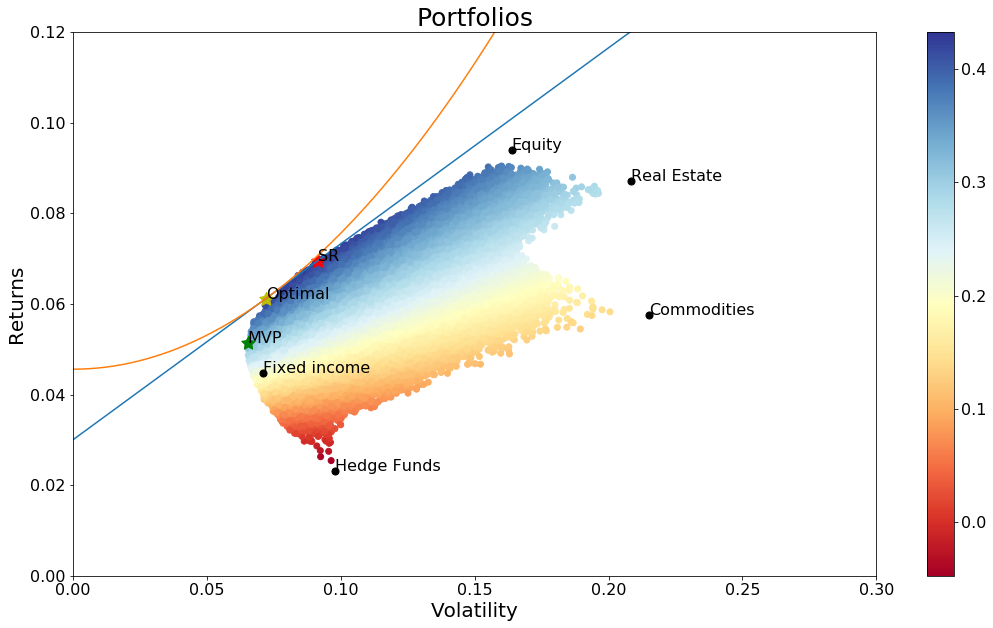

In [23]:
# Set configuration of the graph
plt.figure(figsize=(18, 10))
plt.xlabel('Volatility', fontsize=20)
plt.ylabel('Returns', fontsize=20)
plt.ylim((0.00,0.12))
plt.xlim((0.00,0.3))

## Define the labels
plt.title('Portfolios', fontsize=25)

plt.rc('font', size=16) 


# Create scatter plot coloured by Sharpe Ratio
plt.scatter(results_table_r.stdev,results_table_r.ret,c=results_table_r.sharpe,cmap='RdYlBu')    
plt.colorbar()

# Add classes
plt.scatter(sample_indicators['std'], sample_indicators['mean'], marker="o",color='xkcd:black',s=50)
for i, txt in enumerate(data.columns.tolist()):
    plt.annotate(txt, (sample_indicators['std'].tolist()[i],sample_indicators['mean'].tolist()[i]))

# Plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_r[1],min_vol_r[0],marker=(5,1,0),color='g',s=200)
plt.annotate('MVP', (min_vol_r[1],min_vol_r[0]))    
    
# Plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_r[1],max_sharpe_r[0],marker=(5,1,0),color='r',s=200)
plt.annotate('SR', (max_sharpe_r[1],max_sharpe_r[0]))
             
# Add CML line
graph_formulas(lambda x: (r_f + (max_sharpe_r[0]-r_f)*(x/max_sharpe_r[1])), np.linspace(0.0,0.3, 100))

# Add optimal portfolio 
plt.scatter(std_o_r,E_r_o_r,marker=(5,1,0),color='y',s=200)
plt.annotate('Optimal', (std_o_r,E_r_o_r))

# Add investors utility curve
graph_formulas(lambda x: ((E_r_o_r - gamma*(std_o_r**2)/2)+gamma*(x**2)/2), np.linspace(0.0,0.3, 100))

plt.show();

<br>

Comparing both restricted and not restricted:

In [24]:
question_3

,T_nr,T_r,o_nr_6,o_r_6
E(r),0.121451,0.069599,0.155239,0.061210
σ,0.105498,0.091510,0.144476,0.072122


<br>

Compare different levels of aversion:


In [25]:
# Define different gammas
different_gammas = [2, 4, 8, 10]

In [26]:
# Create a loop that recalculates the returns and the std per value of gamma
for item in different_gammas:
    # Recalculate return and std for 'not restricted' and 'restricted'
    w_T_nr_item, E_r_o_nr_item , std_o_nr_item = Optimal_ret_and_std_per_gamma(E_r_T_nr, std_T_nr, item)
    w_T_r_item, E_r_o_r_item , std_o_r_item = Optimal_ret_and_std_per_gamma(E_r_T_r, std_T_r, item)    
    
    # Add the new value to the comparison table
    question_3['o_nr_'+str(item)] = [E_r_o_nr_item, std_o_nr_item]
    question_3['o_r_'+str(item)] = [E_r_o_r_item, std_o_r_item]

In [27]:
# Show the comparison table with the new results varying with gamma
question_3

,T_nr,T_r,o_nr_6,o_r_6,o_nr_2,o_r_2,o_nr_4,o_r_4,o_nr_8,o_r_8,o_nr_10,o_r_10
E(r),0.121451,0.069599,0.155239,0.061210,0.405718,0.123629,0.217859,0.076815,0.123929,0.053407,0.105144,0.048726
σ,0.105498,0.091510,0.144476,0.072122,0.433427,0.216367,0.216713,0.108183,0.108357,0.054092,0.086685,0.043273


In [29]:
# Show the comparison table with the new results varying with gamma for not restricted
question_3_o_nr = question_3[['o_nr_2', 'o_nr_4', 'o_nr_6', 'o_nr_8', 'o_nr_10']]
question_3_o_nr

,o_nr_2,o_nr_4,o_nr_6,o_nr_8,o_nr_10
E(r),0.405718,0.217859,0.155239,0.123929,0.105144
σ,0.433427,0.216713,0.144476,0.108357,0.086685


In [28]:
# Show the comparison table with the new results varying with gamma for restricted
question_3_o_r = question_3[['o_r_2', 'o_r_4', 'o_r_6', 'o_r_8', 'o_r_10']]
question_3_o_r

,o_r_2,o_r_4,o_r_6,o_r_8,o_r_10
E(r),0.123629,0.076815,0.061210,0.053407,0.048726
σ,0.216367,0.108183,0.072122,0.054092,0.043273


In [ ]:
# Plot the Returns Volatility scatter
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(question_3_o_r.iloc[1], question_3_o_r.iloc[0], marker='o',color='y',s=25)
ax.scatter(question_3_o_nr.iloc[1], question_3_o_nr.iloc[0], marker='o',color='g',s=25)

# Add the labels to each point
for i, txt in enumerate(question_3.columns.tolist()[2:]):
    ax.annotate(txt, (question_3.iloc[1].tolist()[i+2],question_3.iloc[0].tolist()[i+2]))

# Define the limits for the graph
plt.ylim((0.00,0.45))
plt.xlim((0.00,0.45))

## Define the labels
plt.rc('font', size=16) 

# Define the labels
plt.title('Returns and Volatilities of the Optimal portfolios', fontsize=25)
plt.xlabel('Volatility', fontsize=20)
plt.ylabel('Returns', fontsize=20);

________

## Question 4

__  What is the impact on your prior recommendations if the expected return changes? Perform a sensitivity analysis and comment on the differences. __

In [ ]:
# Specify different expected return changes
better_returns = 1.20
worse_returns = 0.80

In [ ]:
# Update the expected returns with the two options
sample_indicators['mean_better'] = sample_indicators['mean']*better_returns
sample_indicators['mean_worse'] = sample_indicators['mean']*worse_returns

# Show the new table
sample_indicators

________

## Question 5

__  Finally, Mrs. Crusoe asks you to suggest 3 stocks and to estimate expected returns and standard deviation (total, systematic and idiosyncratic) on each of them according to the CAPM. Would you recommend the investment in any of the 3 stocks? Explain. __

In [3]:
# Import the Bloomberg file
bbg_data = pd.read_excel('./bbg_1M.xlsx', index_col='Dates').dropna(axis=1, how='any')

# Define stocks with no empty values
bbg_stocks = bbg_data[bbg_data.columns.tolist()[2:]]

In [4]:
bbg_data

,USGG1M Index,SPX Index,A UN Equity,AAP UN Equity,AAPL UW Equity,ABC UN Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,ADM UN Equity,...,XEC UN Equity,XEL UN Equity,XL UN Equity,XLNX UW Equity,XOM UN Equity,XRAY UW Equity,XRX UN Equity,YUM UN Equity,ZBH UN Equity,ZION UW Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2004-12-31,1.8475,1211.9163,16.2379,29.120,4.6000,14.2349,22.3208,27.0000,31.3700,22.3100,...,37.900,18.2000,77.6500,29.6500,51.2600,28.1000,44.8144,16.9625,80.1200,68.0300
2005-01-31,2.0100,1182.3777,14.8971,28.733,5.4929,14.1378,21.6653,26.0500,28.4500,24.2000,...,36.250,18.1900,74.7800,29.1900,51.6000,28.0350,41.8373,16.7000,78.8500,67.8200
2005-02-28,2.4778,1207.2484,16.1705,33.587,6.4086,14.5369,22.1321,25.5500,30.8750,24.1850,...,40.670,17.7200,75.0000,30.2500,63.5800,27.4850,41.0997,17.5756,85.9000,66.4600
2005-03-31,2.6107,1185.8935,14.9577,33.633,5.9529,13.9035,22.4352,24.1500,33.5913,24.6667,...,39.000,17.3875,72.8700,29.2784,59.8542,27.2350,39.9141,18.6673,77.8100,69.3959
2005-04-29,2.6712,1163.4098,13.9807,35.567,5.1514,14.8718,23.7899,21.7000,29.7405,18.0535,...,35.500,17.3875,70.7857,26.9846,57.2732,27.3601,34.9084,16.9558,81.4200,70.4114
2005-05-31,2.7622,1200.3972,16.1772,39.513,5.6729,15.6763,23.3447,23.2800,33.0662,20.0053,...,37.630,18.6526,75.8001,27.8661,56.7309,28.5565,35.7514,18.5193,76.5800,71.5878
2005-06-30,2.9671,1202.1147,15.5102,43.033,5.2586,16.7882,23.7173,22.6700,28.6253,21.5473,...,38.910,19.9734,75.4376,25.6066,58.0129,27.0598,36.3310,18.8045,76.1700,74.3062
2005-07-29,3.2208,1246.8030,17.6797,45.973,6.0929,17.4292,22.6987,25.0400,29.6455,23.1195,...,41.940,19.8608,72.8021,28.4686,59.3050,27.9367,34.8030,18.9435,82.3600,72.2345
2005-08-31,3.3625,1235.4372,21.6685,40.620,6.7043,18.1344,21.9685,24.4000,27.0450,22.7718,...,42.740,19.6869,70.4503,28.2778,60.7586,26.5437,35.3299,17.1451,82.1700,70.9612


In [5]:
# Find returns of all stocks
bbg_ri = bbg_stocks.pct_change().drop(pd.Timestamp('2004-12-31'))
bbg_ri.head()

,A UN Equity,AAP UN Equity,AAPL UW Equity,ABC UN Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,ADM UN Equity,ADS UN Equity,ADSK UW Equity,...,XEC UN Equity,XEL UN Equity,XL UN Equity,XLNX UW Equity,XOM UN Equity,XRAY UW Equity,XRX UN Equity,YUM UN Equity,ZBH UN Equity,ZION UW Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2005-01-31,-0.082572,-0.013290,0.194109,-0.006821,-0.029367,-0.035185,-0.093083,0.084715,-0.085510,-0.226087,...,-0.043536,-0.000549,-0.036961,-0.015514,0.006633,-0.002313,-0.066432,-0.015475,-0.015851,-0.003087
2005-02-28,0.085480,0.168935,0.166706,0.028229,0.021546,-0.019194,0.085237,-0.000620,-0.091433,0.011917,...,0.121931,-0.025838,0.002942,0.036314,0.232171,-0.019618,-0.017630,0.052431,0.089410,-0.020053
2005-03-31,-0.075001,0.001370,-0.071108,-0.043572,0.013695,-0.054795,0.087977,0.019917,0.024081,0.001851,...,-0.041062,-0.018764,-0.028400,-0.032119,-0.058600,-0.009096,-0.028847,0.062115,-0.094179,0.044175
2005-04-29,-0.065318,0.057503,-0.134640,0.069644,0.060383,-0.101449,-0.114637,-0.268102,0.000000,0.069555,...,-0.089744,0.000000,-0.028603,-0.078344,-0.043121,0.004593,-0.125412,-0.091684,0.046395,0.014633
2005-05-31,0.157109,0.110946,0.101235,0.054096,-0.018714,0.072811,0.111824,0.108112,-0.066337,0.243481,...,0.060000,0.072759,0.070839,0.032667,-0.009469,0.043728,0.024149,0.092210,-0.059445,0.016708


In [6]:
# Create return SPX
bbg_rM = bbg_data['SPX Index'].pct_change().drop(pd.Timestamp('2004-12-31'))
bbg_rM.head()

Dates
2005-01-31   -0.024373
2005-02-28    0.021034
2005-03-31   -0.017689
2005-04-29   -0.018959
2005-05-31    0.031792
Name: SPX Index, dtype: float64

In [7]:
# Create risk free table
bbg_r_f = bbg_data['USGG1M Index'].drop(pd.Timestamp('2004-12-31'))/100
bbg_r_f.head()

Dates
2005-01-31    0.020100
2005-02-28    0.024778
2005-03-31    0.026107
2005-04-29    0.026712
2005-05-31    0.027622
Name: USGG1M Index, dtype: float64

In [22]:
# Create table of betas
bbg_betas = pd.DataFrame(index=['E_r', 'β', 'alpha', 'risk_t', 'risk_s', 'risk_i', 'E_r_SML'])

# Add column of betas
for tick in bbg_stocks.columns:
    expected_return = bbg_ri[tick].mean()*12
    slope, intercept = np.polyfit(bbg_rM-bbg_r_f, bbg_ri[tick] - bbg_r_f , 1)
    risk_t = bbg_ri[tick].var()*12
    risk_s = (slope**2)*(bbg_rM.var()*12)
    risk_i = risk_t - risk_s
    SML = bbg_r_f.mean() + slope*(bbg_rM.mean()*12-bbg_r_f.mean())
    bbg_betas[tick] = [expected_return, slope, intercept, risk_t**(1/2), risk_s**(1/2), risk_i**(1/2), SML]

In [23]:
bbg_betas

,A UN Equity,AAP UN Equity,AAPL UW Equity,ABC UN Equity,ABT UN Equity,ACN UN Equity,ADBE UW Equity,ADM UN Equity,ADS UN Equity,ADSK UW Equity,...,XEC UN Equity,XEL UN Equity,XL UN Equity,XLNX UW Equity,XOM UN Equity,XRAY UW Equity,XRX UN Equity,YUM UN Equity,ZBH UN Equity,ZION UW Equity
E_r,0.163822,0.137341,0.345261,0.172518,0.114120,0.170544,0.182959,0.105377,0.180572,0.160814,...,0.164531,0.132196,0.067732,0.120482,0.078460,0.094006,0.031266,0.166840,0.064479,0.069069
β,1.381703,0.759656,1.093156,0.794942,0.591584,0.936401,1.415322,0.585225,1.421828,1.906508,...,1.455005,0.453611,1.984530,1.121719,0.622709,1.074472,1.399384,0.909258,1.056250,1.316110
alpha,0.007433,0.002970,0.021506,0.006030,0.000425,0.006378,0.009150,-0.000326,0.008974,0.009086,...,0.007758,0.001431,0.001612,0.002879,-0.002433,0.000501,-0.003549,0.005971,-0.002026,-0.000701
risk_t,0.306233,0.271783,0.323426,0.211740,0.176515,0.199831,0.301914,0.283890,0.324610,0.393514,...,0.386737,0.145054,0.436330,0.253843,0.173617,0.206933,0.303488,0.222070,0.247005,0.404821
risk_s,0.189988,0.104455,0.150312,0.109307,0.081344,0.128758,0.194611,0.080470,0.195505,0.262150,...,0.200067,0.062373,0.272878,0.154239,0.085624,0.147743,0.192419,0.125025,0.145237,0.180969
risk_i,0.240173,0.250908,0.286375,0.181344,0.156654,0.152819,0.230822,0.272246,0.259132,0.293481,...,0.330966,0.130960,0.340473,0.201609,0.151034,0.144890,0.234691,0.183531,0.199795,0.362119
E_r_SML,0.121777,0.072009,0.098691,0.074832,0.058562,0.086150,0.124467,0.058053,0.124988,0.163766,...,0.127642,0.047523,0.170008,0.100976,0.061052,0.097196,0.123192,0.083978,0.095738,0.116529


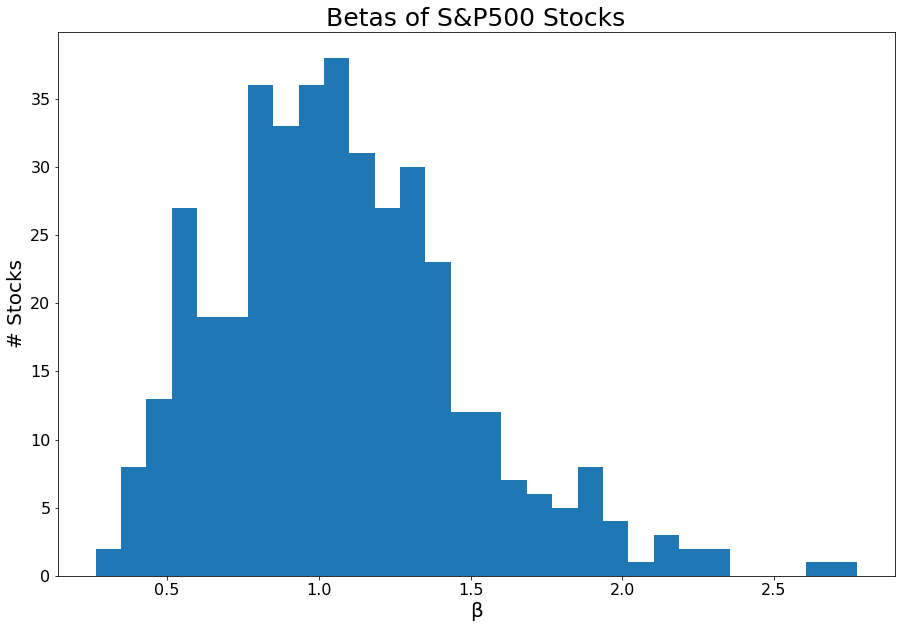

In [24]:
plt.subplots(figsize = (15,10))
plt.hist(bbg_betas.iloc[1].transpose().values.tolist(), bins=30)

plt.rc('font', size=16) 
plt.title('Betas of S&P500 Stocks', fontsize=25)
plt.xlabel('β', fontsize=20)
plt.ylabel('# Stocks', fontsize=20);

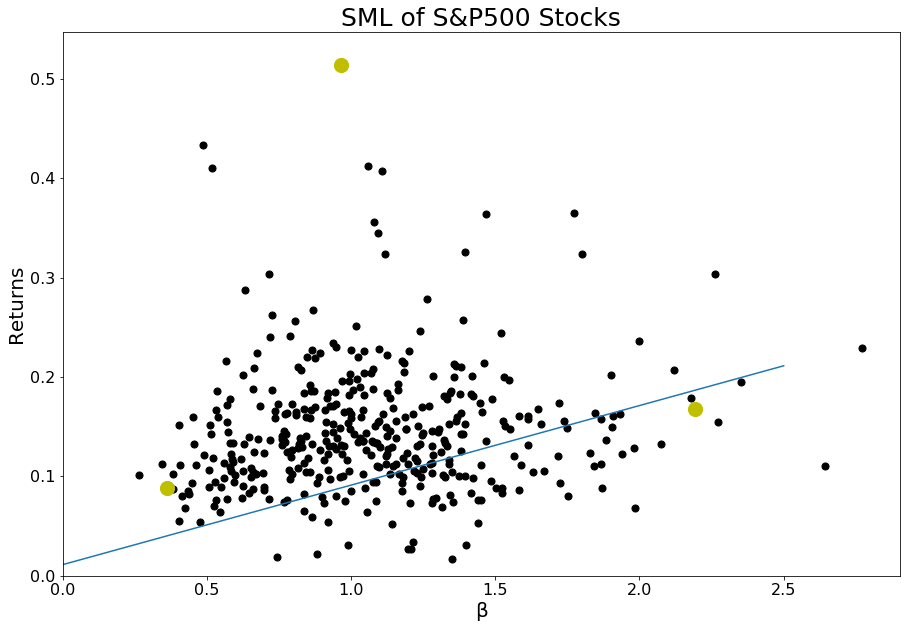

In [25]:
plt.subplots(figsize = (15,10))
plt.scatter(bbg_betas.iloc[[1]].transpose().values, bbg_betas.iloc[[0]].transpose().values, marker="o",color='xkcd:black',s=50)

## Define the limits for the graph
plt.ylim(ymin=0)
plt.xlim(xmin=0)

## Define the labels
plt.title('SML of S&P500 Stocks', fontsize=25)
plt.xlabel('β', fontsize=20)
plt.ylabel('Returns', fontsize=20)
plt.rc('font', size=16) 

for i in ['SO UN Equity', 'LNC UN Equity', 'NFLX UW Equity' ]:
    plt.scatter(bbg_betas[i][1],bbg_betas[i][0],marker='o',color='y',s=200)

## Add SML line
graph_formulas(lambda x: (bbg_r_f.mean() + x*(bbg_rM.mean()*12-bbg_r_f.mean())), np.linspace(0.0,2.5, 100));

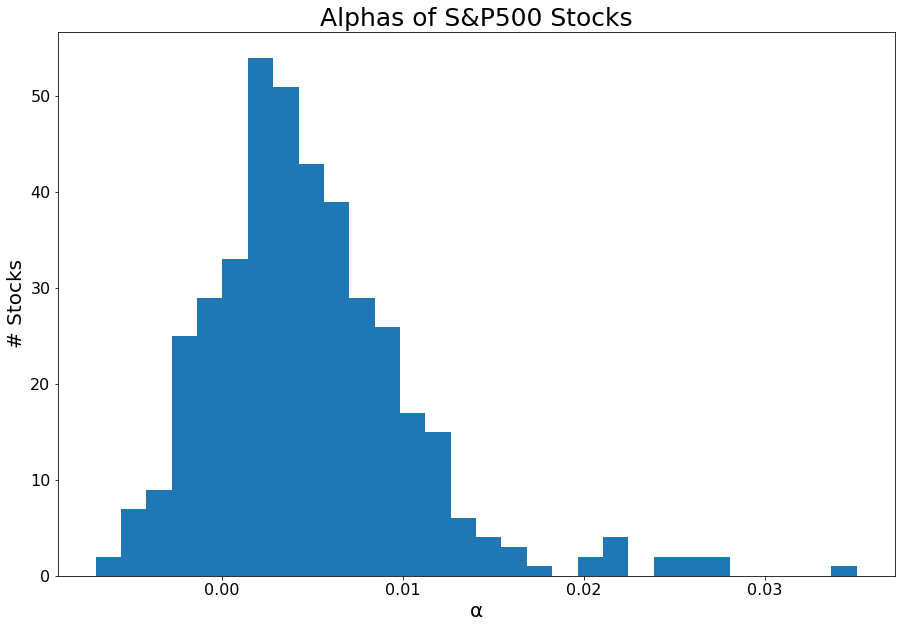

In [26]:
plt.subplots(figsize = (15,10))
plt.hist(bbg_betas.iloc[2].transpose().values.tolist(), bins=30)

plt.rc('font', size=16) 
plt.title('Alphas of S&P500 Stocks', fontsize=25)
plt.xlabel('α', fontsize=20)
plt.ylabel('# Stocks', fontsize=20);

In [27]:
bbg_betas.transpose().idxmax()

E_r        NFLX UW Equity
β           MGM UN Equity
alpha      NFLX UW Equity
risk_t      AIG UN Equity
risk_s      MGM UN Equity
risk_i      AIG UN Equity
E_r_SML     MGM UN Equity
dtype: object

In [28]:
bbg_betas.transpose().idxmin()

E_r           C UN Equity
β          SRCL UW Equity
alpha       CTL UN Equity
risk_t       SO UN Equity
risk_s     SRCL UW Equity
risk_i      JNJ UN Equity
E_r_SML    SRCL UW Equity
dtype: object

In [29]:
def sml_maker(stock):
    plt.subplots(figsize = (15,10))

    ## Add SML line
    graph_formulas(lambda x: (bbg_r_f.mean() + x*(bbg_rM.mean()*(365.25/7)-bbg_r_f.mean())), np.linspace(0.0,2.5, 100));    
    plt.scatter(bbg_betas[stock][1],bbg_betas[stock][0],marker='o',color='g',s=200)
    
    plt.scatter(bbg_betas[stock][1],bbg_betas[stock][-1],marker='o',color='y',s=200)
    
    
    plt.ylim(ymin=0)
    plt.xlim(xmin=0)
    
    ## Define the labels
    plt.title('SML of '+stock, fontsize=25)
    plt.xlabel('β', fontsize=20)
    plt.ylabel('Returns', fontsize=20)
    plt.rc('font', size=16);

First Pick: SO

In [30]:
# First Pick
bbg_betas['SO UN Equity']

E_r        0.087955
β          0.362387
alpha     -0.002586
risk_t     0.124938
risk_s     0.049829
risk_i     0.114571
E_r_SML    0.040224
Name: SO UN Equity, dtype: float64

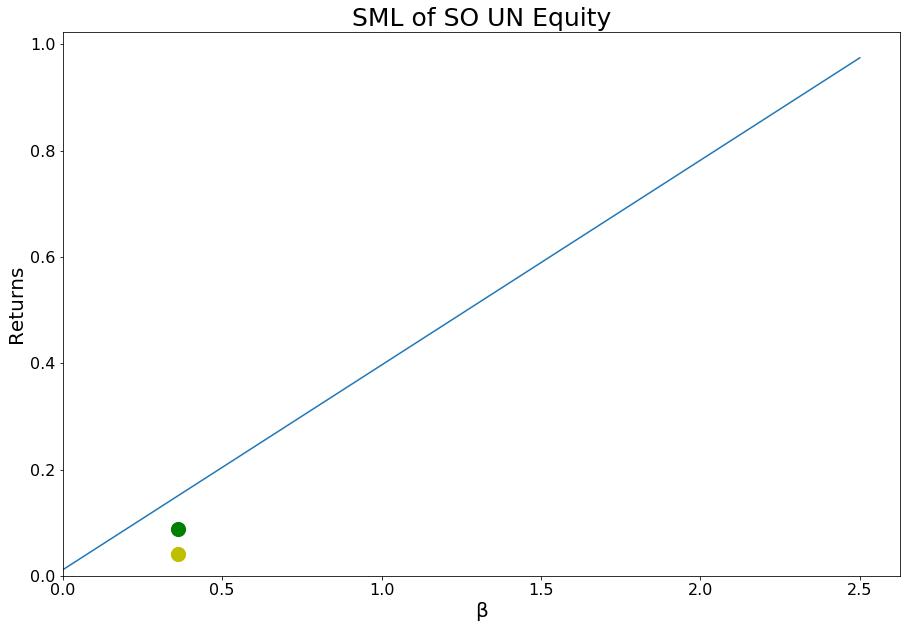

In [31]:
sml_maker('SO UN Equity')

Second Pick: LNC

In [32]:
# Second Pick
bbg_betas['LNC UN Equity']

E_r        0.168174
β          2.193667
alpha      0.010741
risk_t     0.467068
risk_s     0.301635
risk_i     0.356607
E_r_SML    0.186741
Name: LNC UN Equity, dtype: float64

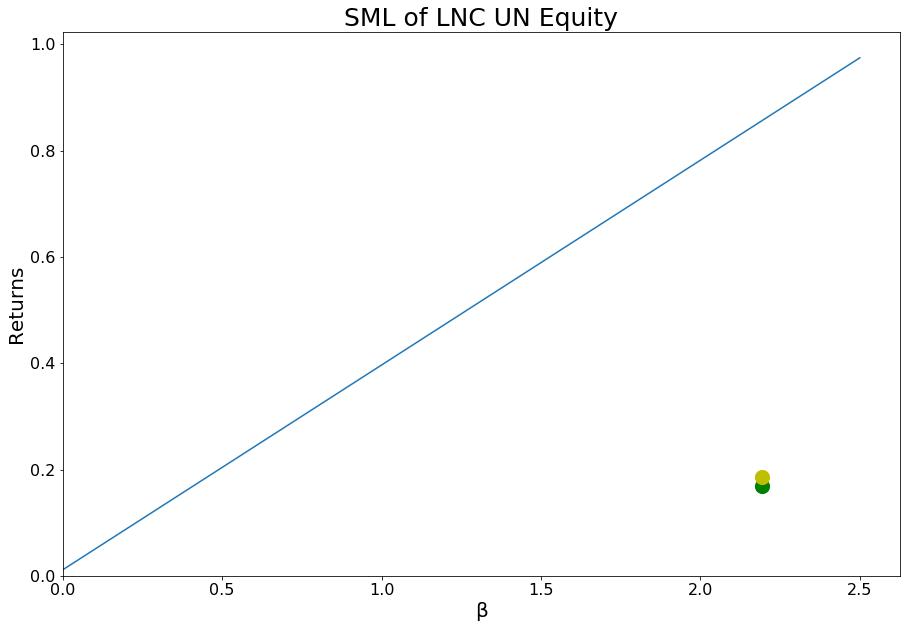

In [33]:
sml_maker('LNC UN Equity')

Third Pick: SO

In [34]:
# Third Pick
bbg_betas['NFLX UW Equity']

E_r        0.513487
β          0.963637
alpha      0.035056
risk_t     0.560459
risk_s     0.132503
risk_i     0.544571
E_r_SML    0.088329
Name: NFLX UW Equity, dtype: float64

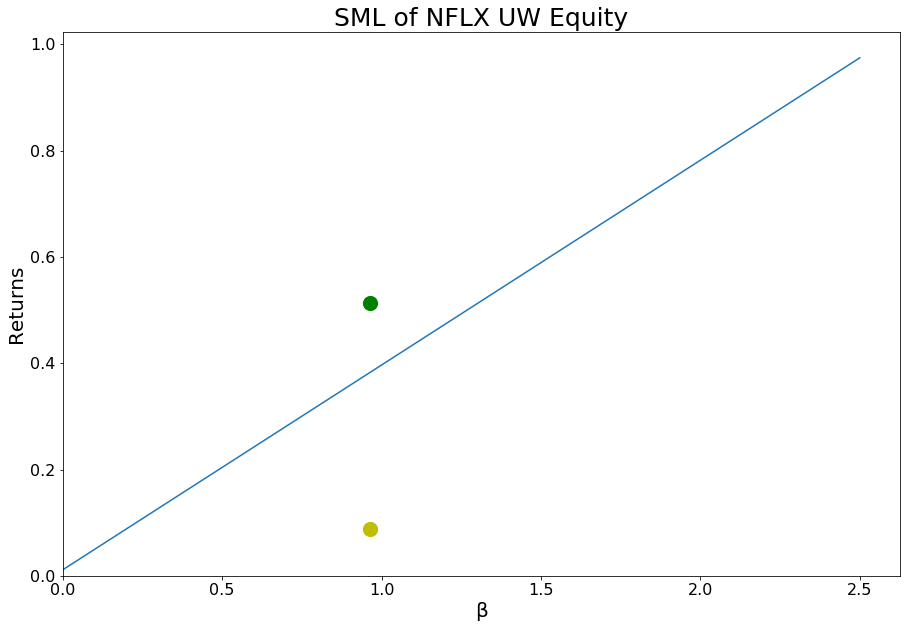

In [35]:
sml_maker('NFLX UW Equity')